In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt

from rdflib import Graph, Literal, URIRef, Namespace, BNode, Literal, Bag
from rdflib.namespace import RDF, RDFS, SH, FOAF, XSD
from rdflib.container import Container

from gensim.parsing.preprocessing import preprocess_string

from nltk.corpus import wordnet

from tqdm.notebook import tqdm, trange
tqdm.pandas()

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# AUTRE SOURCE

In [3]:
tree = ET.parse("../ressources/FOODEX2.xml")

In [4]:
type(tree)

xml.etree.ElementTree.ElementTree

In [5]:
root = tree.getroot()

In [6]:
type(root)

xml.etree.ElementTree.Element

In [7]:
for term in root[0][2]: 
    # term = catalogueTerms in xml file
    for child in term[1]:
        # child is termVersion tag in xml file
        print(child.tag, child.attrib)
    break

version {}
lastUpdate {}
validFrom {}
status {}


In [8]:
# (np.array(terms) == 1).all()

In [9]:
terms = []
for term_element in root[0][2]:
    term = {
        "termCode": term_element.findall(".//termCode")[0].text,
        "termShortName": term_element.findall(".//termShortName")[0].text if len(term_element.findall(".//termShortName")) > 0 else "NA",
        "termExtendedName": term_element.findall(".//termExtendedName")[0].text,
        "version": term_element.findall(".//version")[0].text,
        "lastUpdate": term_element.findall(".//lastUpdate")[0].text,
        "validFrom": term_element.findall(".//validFrom")[0].text,
        "status": term_element.findall(".//status")[0].text,
        "hierarchyCode": term_element.findall(".//hierarchyCode")[0].text,
        "parentCode": term_element.findall(".//parentCode")[0].text,
        "order": term_element.findall(".//order")[0].text,
        "reportable": term_element.findall(".//reportable")[0].text,
    }
    terms.append(term)

In [10]:
df = pd.DataFrame(terms)
df.head()

termCode          termShortName       termExtendedName version  \
0  A.01.001207      Cheese, San Simon      Cheese, San Simon     1.1   
1  A.01.001212          Cheese, Serpa          Cheese, Serpa     1.1   
2  A.01.001214   Cheese, Smoked Gouda   Cheese, Smoked Gouda     1.1   
3  A.01.001215        Cheese, Stilton        Cheese, Stilton     1.1   
4  A.01.001218  Cheese, Tete de Moine  Cheese, Tete de Moine     1.1   

            lastUpdate            validFrom    status hierarchyCode  \
0  2016-01-19T15:02:53  2014-10-30T00:00:00  APPROVED        FOODEX   
1  2016-01-19T15:02:53  2014-10-30T00:00:00  APPROVED        FOODEX   
2  2016-01-19T15:02:53  2014-10-30T00:00:00  APPROVED        FOODEX   
3  2016-01-19T15:02:53  2014-10-30T00:00:00  APPROVED        FOODEX   
4  2016-01-19T15:02:53  2014-10-30T00:00:00  APPROVED        FOODEX   

    parentCode order reportable  
0  A.01.001053   154       true  
1  A.01.001053   159       true  
2  A.01.001053   161       true  
3  A.01.001053   162       true  
4  A.01.001053   165       true

In [11]:
df.shape

(2960, 11)

In [12]:
# top level: food items that are at the root level(has no parent)
df[~df["parentCode"].isin(df["termCode"])].shape

(5, 11)

In [13]:
# low level
df[~df["termCode"].isin(df["parentCode"])].shape

(2593, 11)

In [14]:
def get_level(row):
    parentCode = row["parentCode"]
    if parentCode == "root":
        return 0
    return 1 + get_level(df.loc[df["termCode"] == parentCode].iloc[0])

df['levels'] = df.apply(get_level, axis="columns")

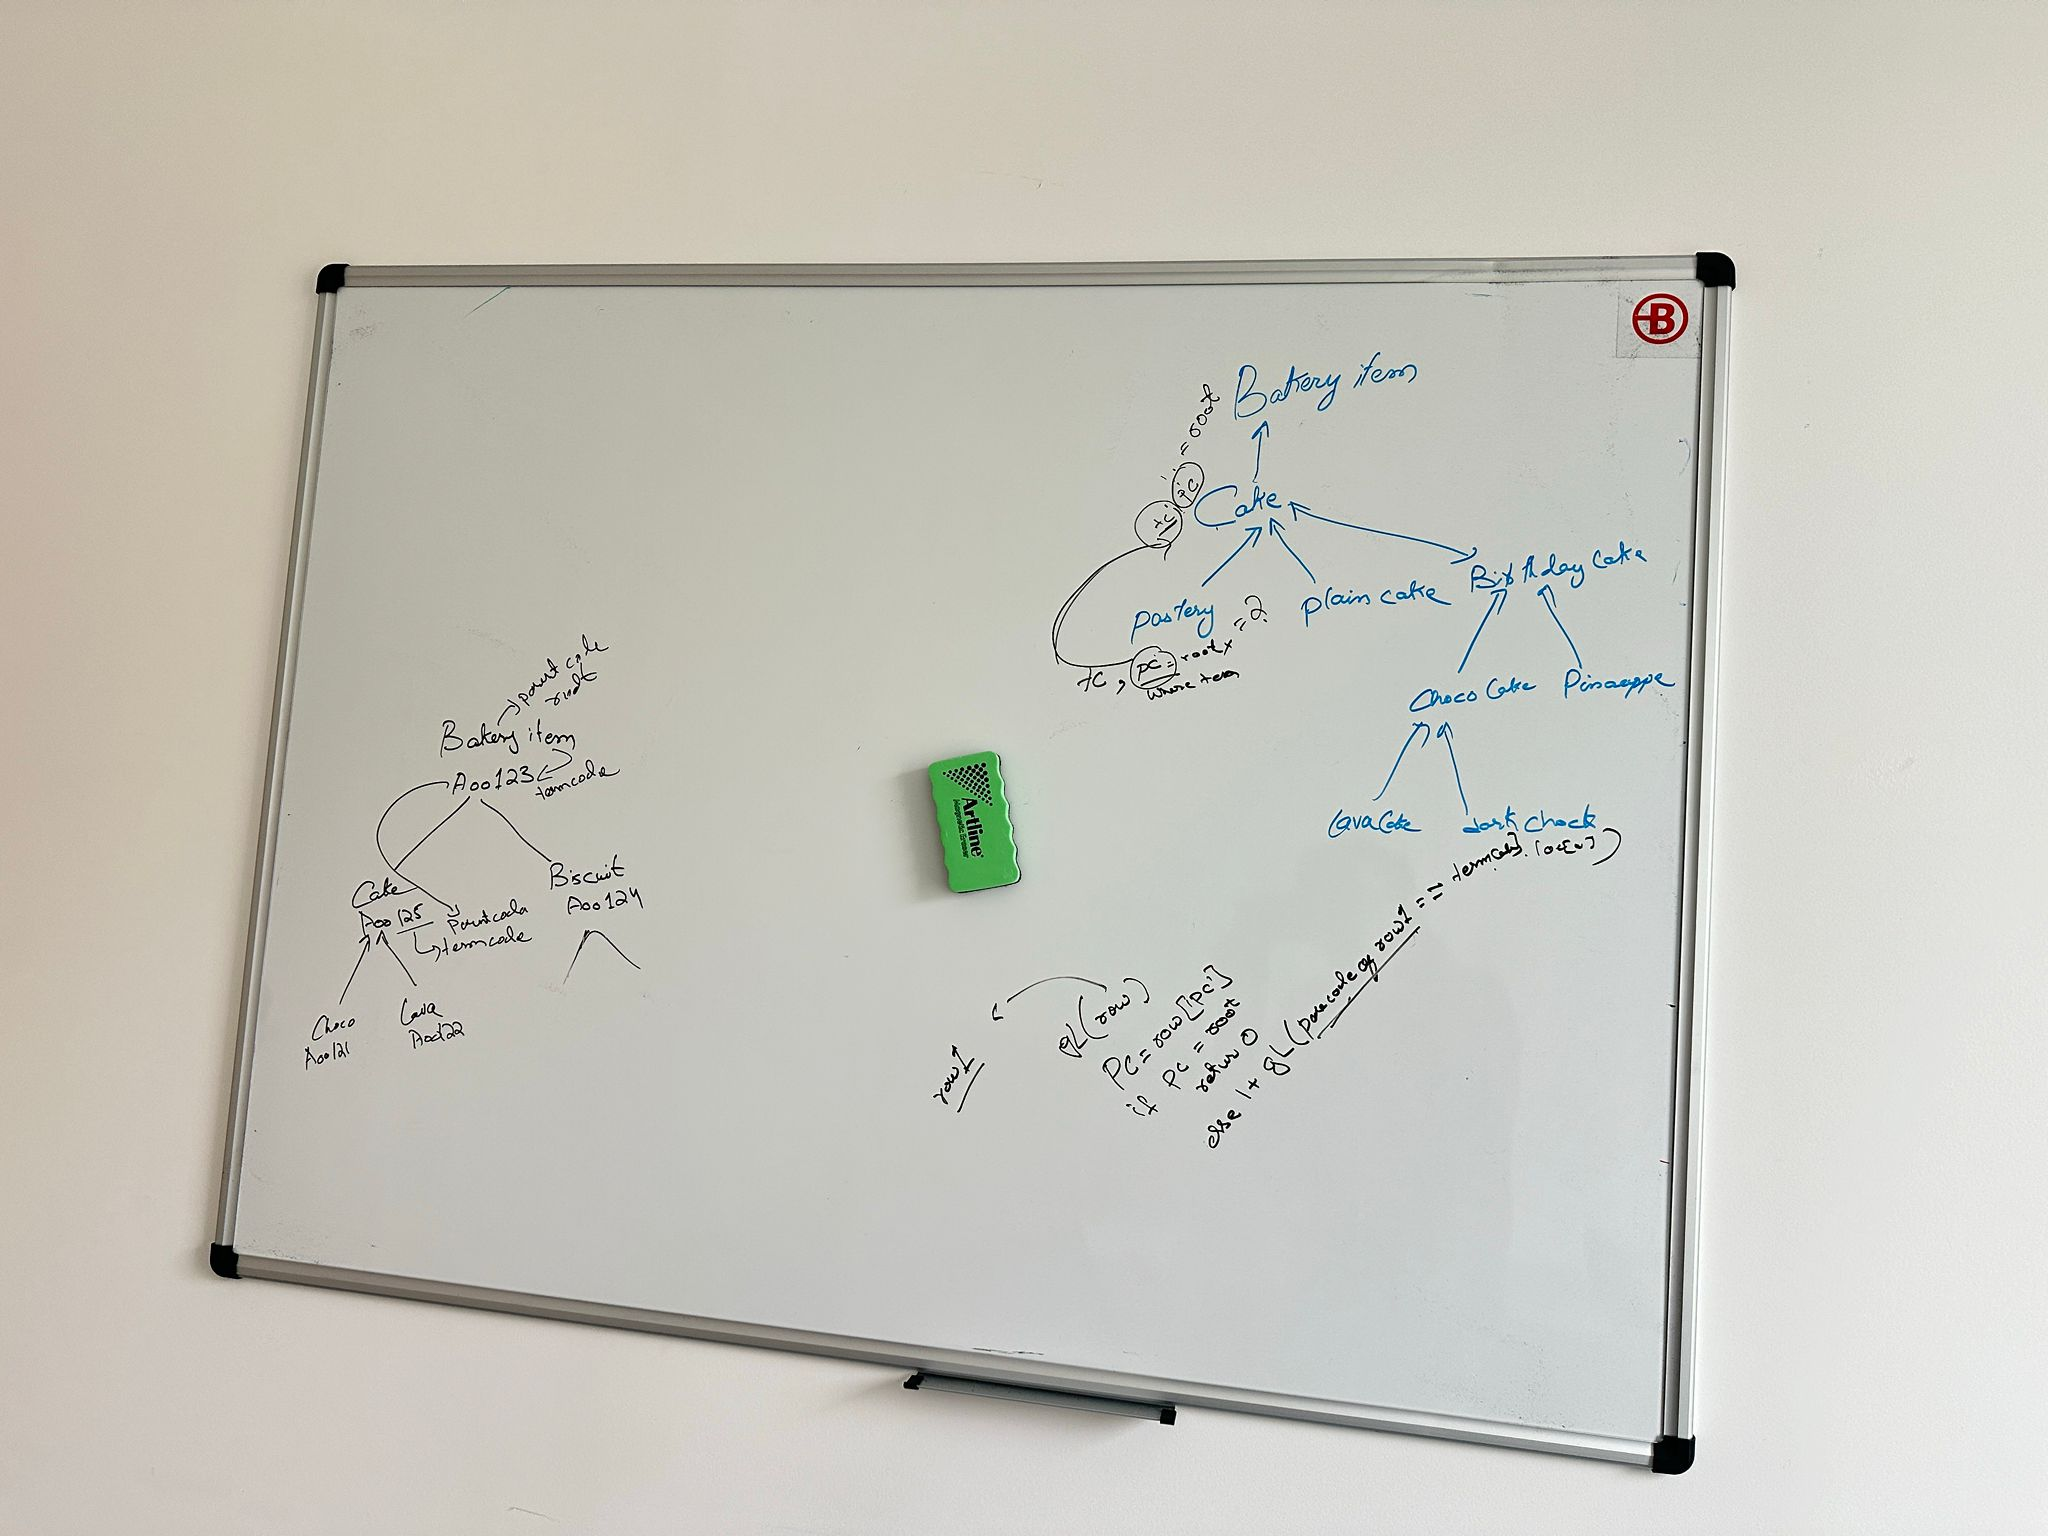

In [15]:
df['levels'].value_counts()

levels
3    1820
2     560
4     500
1      75
0       5
Name: count, dtype: int64

In [16]:
df.head()

termCode          termShortName       termExtendedName version  \
0  A.01.001207      Cheese, San Simon      Cheese, San Simon     1.1   
1  A.01.001212          Cheese, Serpa          Cheese, Serpa     1.1   
2  A.01.001214   Cheese, Smoked Gouda   Cheese, Smoked Gouda     1.1   
3  A.01.001215        Cheese, Stilton        Cheese, Stilton     1.1   
4  A.01.001218  Cheese, Tete de Moine  Cheese, Tete de Moine     1.1   

            lastUpdate            validFrom    status hierarchyCode  \
0  2016-01-19T15:02:53  2014-10-30T00:00:00  APPROVED        FOODEX   
1  2016-01-19T15:02:53  2014-10-30T00:00:00  APPROVED        FOODEX   
2  2016-01-19T15:02:53  2014-10-30T00:00:00  APPROVED        FOODEX   
3  2016-01-19T15:02:53  2014-10-30T00:00:00  APPROVED        FOODEX   
4  2016-01-19T15:02:53  2014-10-30T00:00:00  APPROVED        FOODEX   

    parentCode order reportable  levels  
0  A.01.001053   154       true       3  
1  A.01.001053   159       true       3  
2  A.01.001053   161       true       3  
3  A.01.001053   162       true       3  
4  A.01.001053   165       true       3

In [19]:
df.to_csv("../ressources/FOODEX2.csv")

In [23]:
# levels.value_counts().sort_index()

0       5
1      75
2     560
3    1820
4     500
Name: count, dtype: int64

In [24]:
len(df)

2960

In [ ]:
5 + 75 + 560 + 1820 + 500